In [76]:
# load necessary libraries
library(ggplot2) ## for nice drawings
library(ggforce) ## some more graphics
library(tidyr)   ## (don't forget to install.packages('tidyverse'))
library(tictoc) ## measuring time
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Data pre-processing
To feed the data to `ggplot`/`ggforce`'s method `geom_arc` we need to clean it up in a certain way. Let us look at the raw data:

In [2]:
df = read.csv("./data/refs.xmfa.backbone",sep = "\t")
str(df)

'data.frame':	27729 obs. of  30 variables:
 $ seq0_leftend  : int  0 0 0 0 0 0 -1153904 -1155194 1685700 -1157043 ...
 $ seq0_rightend : int  0 0 0 0 0 0 -1153953 -1155238 1688529 -1157091 ...
 $ seq1_leftend  : int  602660 -762711 0 0 -762709 -762708 0 0 0 0 ...
 $ seq1_rightend : int  602699 -762883 0 0 -762709 -762708 0 0 0 0 ...
 $ seq2_leftend  : int  0 0 0 0 0 0 0 -383069 0 0 ...
 $ seq2_rightend : int  0 0 0 0 0 0 0 -383118 0 0 ...
 $ seq3_leftend  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ seq3_rightend : int  0 0 0 0 0 0 0 0 0 0 ...
 $ seq4_leftend  : int  275041 0 0 0 0 0 0 0 0 0 ...
 $ seq4_rightend : int  275080 0 0 0 0 0 0 0 0 0 ...
 $ seq5_leftend  : int  -1105135 0 0 0 0 0 0 0 0 0 ...
 $ seq5_rightend : int  -1105174 0 0 0 0 0 0 0 0 0 ...
 $ seq6_leftend  : int  0 -263062 -262866 0 0 0 0 0 0 0 ...
 $ seq6_rightend : int  0 -263066 -263062 0 0 0 0 0 0 0 ...
 $ seq7_leftend  : int  0 0 0 -54486 -54483 -54482 0 0 0 0 ...
 $ seq7_rightend : int  0 0 0 -54541 -54483 -54482 0 0 0 0 ...

OK, here is the problem: we need it in the format `segment | sequence | left-end | right-end` instead. Let us reshape it. First, we will "melt" the `leftend` and `rightend` columns -- transform these into a pair of columns `col_name` (will take values `leftend` or `rightend`) and `coordinate` (will hold the coordinate value)

Note that since I don't have anything better I'll use row numbers to identify rows (whatever they are).

In [3]:
## reshape the data frame
## split row "properties" for further re-shaping

df$seg_id = rownames(df) # to identify "segments"

df_lines = df %>%
    pivot_longer(cols = c(ends_with("leftend"), ends_with("rightend")),
                 names_to = "col_name",
                 values_to = "coordinate")

df_lines$seq_id = sub("_.*","",df_lines$col_name)
df_lines$end_type = sub(".*_","",df_lines$col_name)
str(df_lines)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	831870 obs. of  5 variables:
 $ seg_id    : chr  "1" "1" "1" "1" ...
 $ col_name  : chr  "seq0_leftend" "seq1_leftend" "seq2_leftend" "seq3_leftend" ...
 $ coordinate: int  0 602660 0 0 275041 -1105135 0 0 156179 0 ...
 $ seq_id    : chr  "seq0" "seq1" "seq2" "seq3" ...
 $ end_type  : chr  "leftend" "leftend" "leftend" "leftend" ...


In [4]:
# now, just "cast" the dataframe back into the necessary structure
df_lines$col_name = NULL

df_segments = pivot_wider(df_lines, id_cols = c("seq_id","seg_id"),
                          names_from = "end_type",
                          values_from = "coordinate")

str(df_segments)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	415935 obs. of  4 variables:
 $ seq_id  : chr  "seq0" "seq1" "seq2" "seq3" ...
 $ seg_id  : chr  "1" "1" "1" "1" ...
 $ leftend : int  0 602660 0 0 275041 -1105135 0 0 156179 0 ...
 $ rightend: int  0 602699 0 0 275080 -1105174 0 0 156218 0 ...


## Data preprocessing and normalization

In [13]:
# load sequence IDs from a separate file
# WARNING: seq number is inferred from the line number!
load_seq_IDs = function(filename){
    gdf = read.csv(filename,sep = ",")
    gdf$Genome_name = as.character(gdf$Genome_name)
    gdf$Genome_id = as.character(gdf$Genome_id)
    gdf$seq_id = paste("seq",0:(nrow(gdf)-1),sep="")
    return(gdf)
}

## a quick load for debugging:
gdf = load_seq_IDs("./data/genomes.csv")
str(gdf)

'data.frame':	15 obs. of  4 variables:
 $ Genome_name  : chr  "Vibrio alginolyticus.fna" "Vibrio anguillarum.fna" "Vibrio breoganii.fna" "Vibrio campbellii.fna" ...
 $ Genome_id    : chr  "NC_022359.1" "NC_015637.1" "NZ_CP016178.1" "NC_009784.1" ...
 $ Genome_length: int  1812170 988135 1343833 2204018 1072315 1888898 1671895 1303572 2212415 1877212 ...
 $ seq_id       : chr  "seq0" "seq1" "seq2" "seq3" ...


In [92]:
load_circle_data = function(refs_filename, seq_IDs_filename){
    df = read.csv(refs_filename,sep = "\t")
    seq_IDs = load_seq_IDs(seq_IDs_filename)
    
    df$seg_id = rownames(df) # to identify "segments"
    df_lines = df %>%
        pivot_longer(cols = c(ends_with("leftend"), ends_with("rightend")),
                     names_to = "col_name",
                     values_to = "coordinate")
    df_lines$seq_id = sub("_.*","",df_lines$col_name)
    df_lines$end_type = sub(".*_","",df_lines$col_name)
    df_lines$col_name = NULL

    df_segments = pivot_wider(df_lines, id_cols = c("seq_id","seg_id"),
                              names_from = "end_type",
                              values_from = "coordinate")
    
    ## now, drop all the segments that are not present (leftend=rightend=0)
    df_segments = filter(df_segments, !(leftend == 0 & rightend==0))
    
    ## add seq_ID's
    dfc = merge(x=df_segments,y=seq_IDs, by="seq_id")
    
    ## normalize to [0,1] and drop signs:
    dfc$leftend = abs(dfc$leftend) / dfc$Genome_length
    dfc$rightend = abs(dfc$rightend) / dfc$Genome_length
    return(dfc)
}

In [93]:
mydf = load_circle_data("./data/refs.xmfa.backbone","./data/genomes.csv")
str(mydf)

'data.frame':	101632 obs. of  7 variables:
 $ seq_id       : chr  "seq0" "seq0" "seq0" "seq0" ...
 $ seg_id       : chr  "13953" "16452" "16107" "9638" ...
 $ leftend      : num  0.00123 0.76602 0.7046 0.16579 0.05645 ...
 $ rightend     : num  0.00125 0.76602 0.7046 0.16579 0.05646 ...
 $ Genome_name  : chr  "Vibrio alginolyticus.fna" "Vibrio alginolyticus.fna" "Vibrio alginolyticus.fna" "Vibrio alginolyticus.fna" ...
 $ Genome_id    : chr  "NC_022359.1" "NC_022359.1" "NC_022359.1" "NC_022359.1" ...
 $ Genome_length: int  1812170 1812170 1812170 1812170 1812170 1812170 1812170 1812170 1812170 1812170 ...


In [94]:
## Some exploratory data analysis
summary(mydf$leftend)
summary(mydf$rightend)

length(unique(mydf$seg_id))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000005 0.2517724 0.4878282 0.4937304 0.7254614 1.0000000 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000006 0.2519927 0.4879187 0.4938772 0.7255806 1.0000000 

[1] 27717

In [28]:
## normalize the data to be in [0,1]
## this is a toy data for simple
## debugging purposes

dw = read.table(header = T, text='
  seq_id seg_id leftend rightend
  seq1 1 0.0 0.3
  seq1 2 0.4 0.5
  seq1 3 0.6 0.7
  seq2 1 0.4 0.7
  seq2 2 0.8 0.9
  seq3 1 0.1 0.2
')
dw$seq_id = as.character(dw$seq_id)
dw$seg_id = as.character(dw$seg_id)

str(dw)

'data.frame':	6 obs. of  4 variables:
 $ seq_id  : chr  "seq1" "seq1" "seq1" "seq2" ...
 $ seg_id  : chr  "1" "2" "3" "1" ...
 $ leftend : num  0 0.4 0.6 0.4 0.8 0.1
 $ rightend: num  0.3 0.5 0.7 0.7 0.9 0.2


## Making nice figures, finally

In [33]:
## prepare the function
## INPUT: 
## ------
##  a dataframe with the following fields:
##  seq_id: chr, sequence id
##  seg_id: chr, segment id
##  leftend,rightend: num between 0 and 1 -- normalized coordinates
## RETURNS: a ggplot object
draw_circles <- function(df, draw_segment_IDs=FALSE){
    df$seq_id = as.factor(df$seq_id)
    R0 = 2*length(unique(df$seq_id))
    maxval = R0+max(as.numeric(df$seq_id))*2

    plt = ggplot(df)+
        geom_arc(aes(x0=0,y0=0,start=leftend*2*pi, end = rightend*2*pi, r=R0+as.numeric(seq_id), color=seg_id),size=2)+
        geom_segment(x=-maxval,y=0, xend=maxval,yend = 0, color="gray",size=0.1)+
        geom_segment(x=0,y=-maxval, xend=0,yend = maxval, color="gray",size=0.1)+
        geom_segment(x=0,y=0, xend=0,yend = maxval, color="red",linetype="dashed",size=0.5)+
        labs(color="Segment ID")+
        xlab("")+
        ylab("")+
        scale_x_continuous(labels=NULL,breaks=NULL,limits = c(-maxval,maxval))+
        scale_y_continuous(labels=NULL,breaks=NULL,limits = c(-maxval, maxval))+
        theme_void()+
        coord_fixed()
    
    if (draw_segment_IDs == FALSE){
        plt = plt + theme(legend.position = "none")
    }
    return(plt)
}

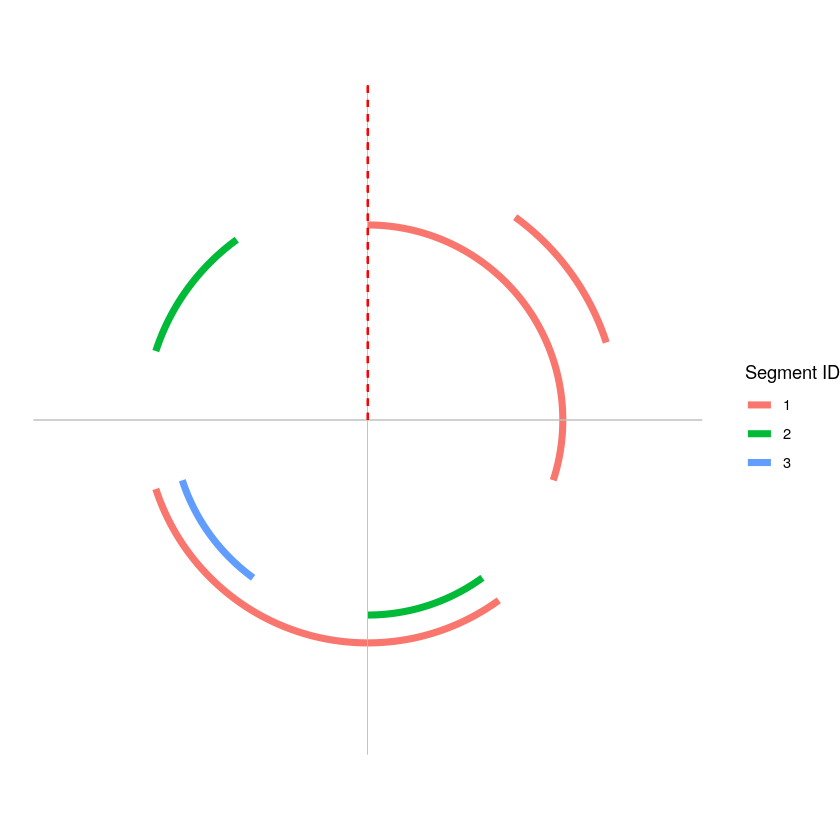

In [34]:
## test it
draw_circles(dw, TRUE)

In [95]:
## the real example
## load and prepare the data
tic()
mydf = load_circle_data("./data/refs.xmfa.backbone","./data/genomes.csv")
toc()

## design the ggplot object
tic()
plt = draw_circles(mydf)
toc()

2.722 sec elapsed
0.02 sec elapsed


156.841 sec elapsed


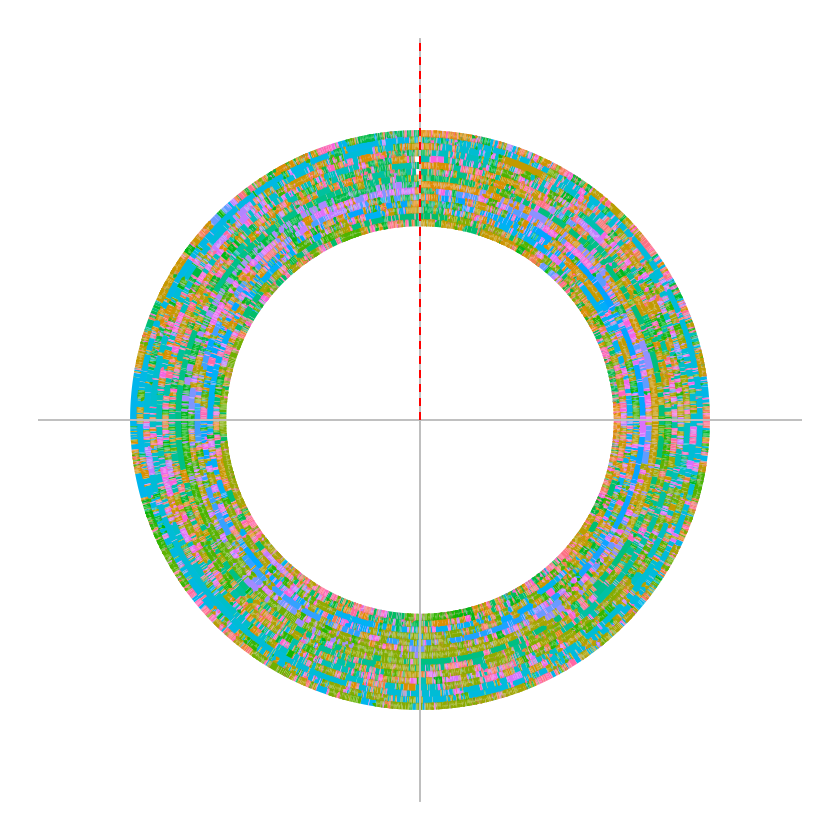

In [96]:
## draw the ggplot
tic()
plt
toc()

In [142]:
## save
tic()
ggsave("./results/circle_plot.png", plt, width=10, height = 10)
toc()

166.855 sec elapsed


## Some further analysis
Since the figure above is unreadable, let us narrow down the data set restricting it to the most "popular" segments only. Let us find these:

In [144]:
segment_freqs = with(mydf, 
                        data.frame(
                            tapply(seq_id, seg_id,
                                   FUN=function(x) length(unique(x)) 
                                   ))
                    )
segment_freqs$seg_id = rownames(segment_freqs)

colnames(segment_freqs) = c("UniqueSeqs","seg_id")
segment_freqs = segment_freqs[ order(segment_freqs$UniqueSeqs, decreasing = TRUE), ]

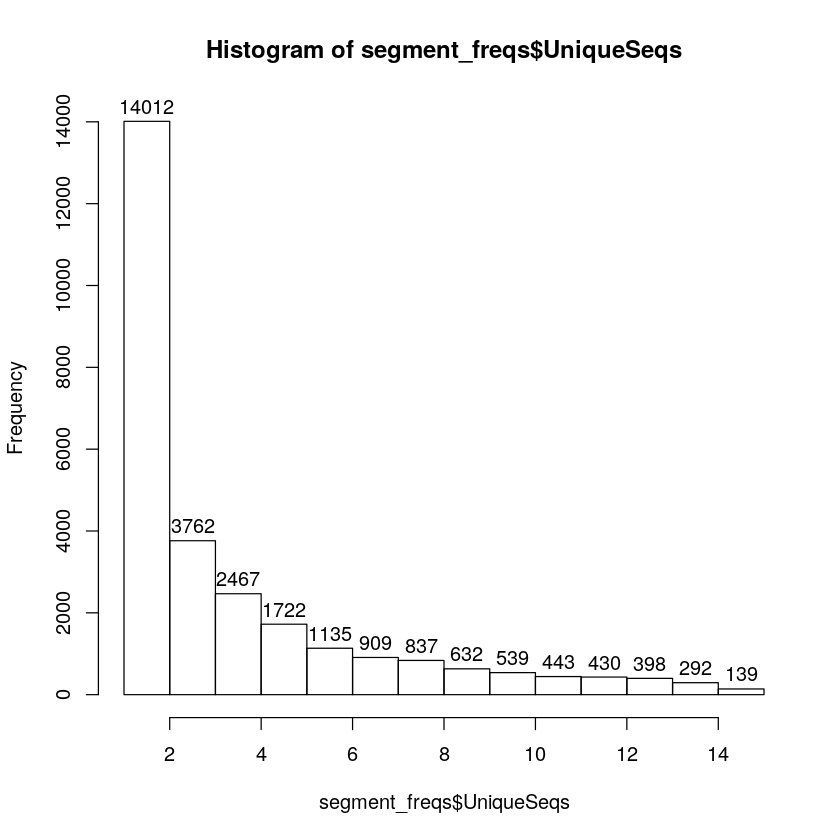

In [145]:
h <- hist(segment_freqs$UniqueSeqs)
text(h$mids,h$counts,labels=h$counts, adj=c(0.5, -0.5))

In [146]:
popular_segments = segment_freqs$seg_id[ segment_freqs$UniqueSeqs == 15 ]
length(popular_segments)
popular_segments

[1] 139

[1] "11924" "11926" "11990" "12000" "12200" "12296" "12297" "12306" "12449"
 [10] "12506" "12523" "12538" "13218" "13224" "13404" "13413" "13414" "13418"
 [19] "13433" "13438" "13442" "13500" "13506" "13508" "13510" "13511" "13518"
 [28] "13527" "13533" "13582" "13587" "13591" "13596" "13602" "13607" "13611"
 [37] "13797" "13816" "13827" "13852" "13873" "13895" "13981" "14029" "14031"
 [46] "14549" "14550" "14570" "14574" "14576" "14579" "14592" "14593" "14621"
 [55] "14629" "14668" "14671" "14807" "14814" "14832" "14985" "15185" "15200"
 [64] "15227" "15251" "15299" "15308" "15313" "15315" "15317" "15335" "15337"
 [73] "15338" "15456" "15482" "15549" "15561" "15580" "15596" "15609" "15611"
 [82] "15613" "15629" "15753" "15766" "15768" "15774" "15888" "15890" "15909"
 [91] "15972" "15974" "16016" "16017" "16034" "16039" "16095" "16097" "16099"
[100] "16117" "16158" "16178" "16180" "16191" "16193" "16251" "16323" "16331"
[109] "16349" "16358" "16635" "16636" "16643" "17271" "17281" "17292" "17294"
[118] "17351" "17390" "17535" "17641" "17769" "17772" "17980" "18001" "18002"
[127] "18198" "19044" "19048" "19050" "19052" "19054" "19058" "19096" "19285"
[136] "19297" "19299" "19305" "19311"

In [152]:
## now, narrow down the data and make a ggplot
tic()
narrowed_df = filter(mydf, seg_id %in% popular_segments)
plt_n = draw_circles(narrowed_df)
toc()

0.049 sec elapsed


In [153]:
## save the result
tic()
ggsave("./results/narrowed_circle.png", plt_n, width = 10, height = 10)
toc()

3.24 sec elapsed
